Complete both tasks, using either a notebook or a Python script. Marks will be given for

* Correct implementation of algorithms to solve the tasks (10/20)
* Complete documentation of code, especially functions, and discussion of results (6/20)
* Unit tests and/or code robustness through eg assertions, as appropriate (4/20)

## Finite elements - the big G

Solve the heat equation

$$
  \nabla^2 T + f(x, y) = 0
$$

on the domain $\Omega$, where $\Omega$ looks like the figure below:

In [1]:
import timeit
import pytest
import sympy
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12, 6)

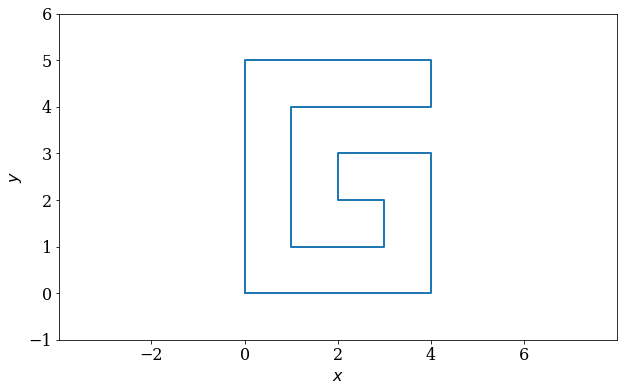

In [2]:
domain = np.array([[0.0, 0.0], [4.0, 0.0], [4.0, 3.0], [2.0, 3.0], [2.0, 2.0], [3.0, 2.0], [3.0, 1.0],
                   [1.0, 1.0], [1.0, 4.0], [4.0, 4.0], [4.0, 5.0], [0.0, 5.0], [0.0, 0.0]])
plt.figure(figsize=(10,6))
plt.plot(domain[:,0],domain[:,1], lw=2)
plt.axis('equal')
plt.xlim(-1,5)
plt.ylim(-1,6)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

The temperature $T$ is fixed to be $0$ along the whole right boundary where $x=4$. On all other boundaries the normal derivative of the temperature vanishes. The heat source $f(x, y)$ is given by

$$
  f = \exp(-(x^2 + y^2)).
$$

### Tasks

1. Using the grid generation function below, and a finite element algorithm using linear elements as in the lab, compute and plot the solution of the heat equation with triangles of side-length $1/2$ and $1/16$.

In [3]:
# =============================================================================
# Grid Generation - provided by Dr Ian Hawke
# =============================================================================

def find_node_index_of_location(nodes, location):
    """
    Given all the nodes and a location (that should be the location of
    *a* node), return the index of that node.

    Parameters
    ----------

    nodes : array of float
        (Nnodes, 2) array containing the x, y coordinates of the nodes
    location : array of float
        (2,) array containing the x, y coordinates of location
    """

    dist_to_location = np.linalg.norm(nodes - location, axis=1)
    return np.argmin(dist_to_location)


def generate_g_grid(side_length):
    """
    Generate a 2d triangulation of the letter G. All triangles have the same
    size (right triangles, short length side_length)

    Parameters
    ----------

    side_length : float
        The length of each triangle. Should be 1/N for some integer N

    Returns
    -------

    nodes : array of float
        (Nnodes, 2) array containing the x, y coordinates of the nodes
    IEN : array of int
        (Nelements, 3) array linking element number to node number
    ID : array of int
        (Nnodes,) array linking node number to equation number; value is -1 if
        node should not appear in global arrays.
    """

    if side_length > 1:
        raise ValueError('side_length should be 1/N, where N is an integer, \
                         hence sidelength should be <= 1.')
    elif side_length == 0:
        raise ValueError('The value of side_length cannot be zero, as the \
                         elements will have no length.')
    elif side_length < 0:
        raise ValueError('side_length is < 0. I\'m not sure what a negative \
                         length is!')

    x = np.arange(0, 4 + 0.5 * side_length, side_length)
    y = np.arange(0, 5 + 0.5 * side_length, side_length)
    X, Y = np.meshgrid(x, y)
    potential_nodes = np.zeros((X.size, 2))
    potential_nodes[:, 0] = X.ravel()
    potential_nodes[:, 1] = Y.ravel()
    xp = potential_nodes[:, 0]
    yp = potential_nodes[:, 1]
    nodes_mask = np.logical_or(
            np.logical_and(xp >= 2, np.logical_and(yp >= 2,yp <= 3)),
                np.logical_or(np.logical_and(xp >= 3,yp <= 3),
                    np.logical_or(xp<=1, np.logical_or(yp<=1, yp>=4))))
    nodes = potential_nodes[nodes_mask, :]

    ID = np.zeros(len(nodes), dtype=np.int)
    n_eq = 0
    for nID in range(len(nodes)):
        if np.allclose(nodes[nID, 0], 4):
            ID[nID] = -1
        else:
            ID[nID] = n_eq
            n_eq += 1

    inv_side_length = int(1/side_length)
    Nelements_per_block = inv_side_length ** 2
    Nelements = 2 * 14 * Nelements_per_block
    IEN = np.zeros((Nelements, 3), dtype=np.int)
    block_corners = [[0, 0], [1, 0], [2, 0], [3, 0], [0, 1], [3, 1], [0, 2],
                     [2, 2], [3, 2], [0, 3], [0, 4], [1, 4], [2, 4], [3, 4]]
    current_element = 0
    for block in block_corners:
        for i in range(inv_side_length):
            for j in range(inv_side_length):
                node_locations = np.zeros((4, 2))
                for a in range(2):
                    for b in range(2):
                        node_locations[a + 2 * b, 0] = block[0] + \
                            (i + a) * side_length
                        node_locations[a + 2 * b, 1] = block[1] + \
                            (j + b) * side_length
                index_lo_l = find_node_index_of_location(nodes,
                                                         node_locations[0, :])
                index_lo_r = find_node_index_of_location(nodes,
                                                         node_locations[1, :])
                index_hi_l = find_node_index_of_location(nodes,
                                                         node_locations[2, :])
                index_hi_r = find_node_index_of_location(nodes,
                                                         node_locations[3, :])
                IEN[current_element, :] = [index_lo_l, index_lo_r, index_hi_l]
                current_element += 1
                IEN[current_element, :] = [index_lo_r, index_hi_r, index_hi_l]
                current_element += 1

    return nodes, IEN, ID

In [4]:
# =============================================================================
# Finite Element Helper Functions
# =============================================================================

def shape_function(xi):
    """
    Compute the value of the shape functions at an element's location given
    the reference locations of the nodes, (xi, eta).


    Parameters
    ----------
    xi: 1 x 2 array of floats.
        The reference coordinates of an element (xi, eta).

    Returns
    -------
    N: 3 x 1 array of floats.
        The value of the shape functions at the reference coordinates
        (xi, eta).
    """

    assert(len(xi) == 2), \
        'Only two reference coordinates should be provided.'

    N = np.array([[1 - xi[1] - xi[0]], [xi[0]], [xi[1]]])

    return N


def shape_function_dN():
    """
    Compute the derivatives of the shape functions at the reference points
    of an element with coordinates (xi, eta).

    As linear shape functions will always be used, the derivatives will either
    be 0, -1 or 1.

    Returns
    -------
    dN: 1 x 3 array of ints.
        An array containing the values of the differential at the reference
        coordinates (xi, eta) for an element.
    """

    dN = np.array([[-1, -1], [1, 0], [0, 1]])

    return dN


def local_to_global(nodes, xi):
    """
    Converts the local coordinates of an elements reference coordinates to the
    global coordinates for an element on the mesh.

    Parameters
    ----------
    nodes: 3 x 2 array of floats.
        The global locations of the nodes of the triangular element.
    xi: 1 x 2 array of floats.
        The reference coordinates of an element (xi, eta).

    Returns
    -------
    global_coords: 1 x 2 array.
        The global coordinates of the element on the mesh.
    """

    assert(len(xi) == 2), \
        'Only two reference coordinates should be provided.'
    assert(nodes.shape == (3, 2)), \
        'nodes needs to be an array of shape (3, 2).'

    N = shape_function(xi)

    x = nodes[0, 0] * N[0] + nodes[1, 0] * N[1] + nodes[2, 0] * N[2]
    y = nodes[0, 1] * N[0] + nodes[1, 1] * N[1] + nodes[2, 1] * N[2]

    global_coords = np.hstack((x, y))

    return global_coords


def jacobian(nodes):
    """
    Compute the Jacobian matrix of an element with a global location defined
    by nodes.

    Parameters
    ----------
    nodes: 3 x 2 array of floats.
        The global locations of the nodes of the triangular element.

    Returns
    -------
    J: 2x2 matrix of floats.
        The Jacobian matrix, i.e. the matrix of derivatives, at the global
        location of an element.
    """

    assert(nodes.shape == (3, 2)), \
        'nodes needs to be an array of shape (3, 2).'

    dN = shape_function_dN()    
    J = np.dot(dN.T, nodes)  # costruct the Jacobian matrix

    return J


def det_jacobian(nodes):
    """
    Compute the deterimnant of the Jacobian matrix of an element with a
    global location defined by nodes.

    Parameters
    ----------
    nodes: 3 x 2 array of floats.
        The global locations of the nodes of the triangular element.

    Returns
    -------
    The determinant of the Jacobian matrix for an element with global location
    nodes and reference coordiante (xi, eta).
    """

    assert(nodes.shape == (3, 2)), \
        'nodes needs to be an array of shape (3, 2).'

    J = jacobian(nodes)
        
    return np.abs(np.linalg.det(J))


def global_dN(nodes):
    """
    Computes the deriatives of the shape functions for an element given its
    global position nodes and reference coordinates (xi, eta).

    Parameters
    ----------
    nodes: 3 x 2 array of floats.
        The global locations of the nodes of the triangular element.

    Returns
    -------
    global_dN: 3 x 2 array of ints.
        The value of the derivatives of the shape functions for an element with
        global location nodes and reference locations (xi, eta).
    """

    assert(nodes.shape == (3, 2)), \
        'nodes needs to be an array of shape (3, 2).'

    dN = shape_function_dN()
    J = jacobian(nodes)
    global_dN = np.zeros_like(dN)

    # solve the linear equation global_dN * J = dN
    for i in range(3):
        global_dN[i, :] = np.linalg.solve(J, dN[i, :])

    return global_dN


def reference_quad(psi):
    """
    Computes the volume of the reference triangle for an element using Gauss
    quadrature given a function psi.

    Parameters
    ----------
    psi: function, with argument xi.
        This function is used to calculate the volume of the reference element.
        It is applied at each point of the reference element, (xi, eta).

    Returns
    -------
    reference_quad: float.
        The volume of the reference element given by the Gauss quadrature of
        the reference points xi1, xi2 and xi3.
    """

    
    # the reference points for the quadrature will always be the same, hence
    # define them here
    xi1 = [1/6, 1/6]
    xi2 = [4/6, 1/6]
    xi3 = [1/6, 4/6]

    reference_quad = (1/6) * (psi(xi1) + psi(xi2) + psi(xi3))
    
    # this quadrature should always be a float, and not an array or etc, so 
    # check to make sure nothing weird has happened somewhere
    assert(type(reference_quad) == float or int), \
        'The reference quadrature is being calculated in the wrong format.'
    
    return reference_quad


def element_quad(phi, nodes):
    """
    Compute the volume of the element given a function phi using Gauss
    quadrature.

    Parameters
    ----------
    nodes: 3 x 2 array of floats.
        The global locations of the nodes of the triangular element.
    phi: function, with arguments nodes, N, dN.
        Where nodes is the global x, y locations of the element, N is the value
        of the shape functions at the reference nodes in the element and dN is
        the derivitive of the shape functions at the reference nodes in the
        element. This function is used to compute the volume of an element.

    Returns
    -------
    quad: float.
        The volume of the element given by the Gauss quadrature.
    """

    assert(nodes.shape == (3, 2)), \
        'nodes needs to be an array of shape (3, 2).'

    def psi(xi):
        return det_jacobian(nodes) * phi(
            local_to_global(nodes, xi), shape_function(xi),
                global_dN(nodes))
    
    quad = reference_quad(psi)

    return quad


def local_stiffness(nodes):
    """
    Computes the local stiffness matrix for an element given ithe global node
    locations of the element.

    Parameters
    ----------
    nodes: 3 x 2 array of floats.
        The global locations of the nodes of the triangular element.

    Returns
    -------
    k_ab: n_dim + 1 x n_dim + 1 array of floats.
        The local stiffness matrix for an element, where n_dim is the number of
        dimensions of the element.
    """

    assert(nodes.shape == (3, 2)), \
        'nodes needs to be an array of shape (3, 2).'

    # The number of equations is equal to the number of dimensions + 1
    N_eq = nodes.shape[1] + 1  
    k_ab = np.zeros((N_eq, N_eq))

    # loop over the node reference points
    for a in range(N_eq):
        for b in range(N_eq):
            # define the vector phi for the element quadrature
            def phi_k(nodes, N, dN):
                return dN[a, 0] * dN[b, 0] + dN[a, 1] * dN[b, 1]

            k_ab[a, b] = element_quad(phi_k, nodes)

    return k_ab


def local_force(nodes, force_func):
    """
    Computes the local force vector of an element given the global node
    locations of the element.

    Parameters
    ----------
    nodes: 3 x 2 array of floats.
        The global locations of the nodes of the triangular element.
    force_func: function.
        Requires one argument which will be a 1 x 2 array containing the x, y
        coordinates of the node location for a reference point in an element.
        The force function used to calculate the local force vector for each
        element. The function should accept one argument which is an array
        containing the global x and y coordinates for a reference point of an
        element.

    Returns
    -------
    f_b: 1 x n_dim + 1 array of floats.
        The local force vector for an element, where n_dim is the number of
        dimensions of the element.
    """

    assert(nodes.shape == (3, 2)), \
        'nodes needs to be an array of shape (3, 2).'

    # The number of equations is equal to the number of dimensions + 1
    N_eq = nodes.shape[1] + 1
    f_b = np.zeros(N_eq)

    # loop over the b reference points
    for b in range(N_eq):
        # define the vector phi
        def phi_f(nodes, N, dN):
            return N[b] * force_func(nodes)

        f_b[b] = element_quad(phi_f, nodes)

    return f_b

In [5]:
# =============================================================================
# Finite Element Algorithm
# =============================================================================

def finite_element_2d(nodes, IEN, ID, force_func):
    """
    The finite element algorithm to solve for T. This function works by
    consturcting a location matrix to link elements to node. Each element then
    has its local stiffness matrix Kab and local force vector Fb calculated.
    The global stiffness and force matrices are then computed using Kab and Fb
    and used to solve the linear equation K * T = F, which returns the values
    of the temperatures at each node.

    Parameters
    ----------
    nodes: N x 2 array of floats.
        An array containing the global x, y cooridnates of the nodes for the
        element mesh.
    IEN: n_elements x n_dim + 1 array of ints.
        An array containing how each element in the mesh is related to the
        nodes.
    ID: 1 x n_elements array of ints.
        An array linking the global node locations to the global equation
        number in the global stiffness and force matrices.
    force_func: function.
        Requires one argument which will be a 1 x 2 array containing the x, y
        coordinates of the node location for a reference point in an element.
        The force function used to calculate the local force vector for each
        element. The function should accept one argument which is an array
        containing the global x and y coordinates for a reference point of an
        element.

    Returns
    -------
    T: 1 x nodes array of floats.
        The array of temperatures at each global node, where nodes is the
        number of nodes.
    """

    assert(ID.shape[0] == nodes.shape[0]), 'The ID array has incorrect \
        dimensions, it should have as many elements as there are nodes.'
    assert(nodes.shape[1] == 2), \
        'nodes needs to be an array of 2 columns for the x and y coordinates.'
    assert(len(nodes) > 2), 'There are not enough nodes to define a triangular \
        element.'
    assert(IEN.shape[1] == 3), \
        'Each element has 3 node numbers associated to it, hence there should \
        be 3 columns per element.'

    # get the number of the equations, elements and nodes
    N_eq = np.max(ID) + 1
    N_elements = IEN.shape[0]
    N_nodes, N_dim = nodes.shape

    # generate the location matrix which links the node locations to an element
    LM = np.zeros_like(IEN.T)
    for e in range(N_elements):
        for a in range(N_dim + 1):
            LM[a, e] = ID[IEN[e, a]]

    # create arrays for global stiffness matrix and global force vector
    K_global = np.zeros((N_eq, N_eq))
    F_global = np.zeros(N_eq)

    for e in range(N_elements):
        # calculate the local stiffness and force for each element
        k_ab = local_stiffness(nodes[IEN[e, :], :])
        f_b = local_force(nodes[IEN[e, :], :], force_func)
        
        # loop over the reference coords
        for a in range(N_dim + 1):
            A = LM[a, e]
            for b in range(N_dim + 1):
                B = LM[b, e]
                if (A >= 0) and (B >= 0):
                    # if A or B < 0, then the node will be ignored
                    K_global[A, B] += k_ab[a, b]
            if (A >= 0):
                # if A, then the node will be ignored
                F_global[A] += f_b[a]

    # Solve the linear equation, k * T = F
    T_A = np.linalg.solve(K_global, F_global)

    # now construct the array to contain T at the nodes
    T = np.zeros(N_nodes)
    for node in range(N_nodes):
        # if ID < 0, this temperature should not appear in the global array
        if ID[node] >= 0:
            T[node] = T_A[ID[node]]

    return T

In [6]:
# =============================================================================
# Plotting Functions
# =============================================================================

def plot_temperature_triplot(nodes, IEN, tri_size, T, cmap='hot'):
    """
    Plot the temperature of the grid using the tripcolor function in matplotlib
    to plot the temperature as a colourmap.

    Parameters
    ----------
    nodes: N x N array of floats.
        An array containing the global x, y cooridnates of the nodes for the
        element mesh.
    IEN: n_elements x n_dim + 1 array of ints.
        An array containing how each element in the mesh is related to the
        nodes.
    tri_size: float.
        The length of the short side of the triangular elements.
    T: 1 x nodes array of floats.
        The array of temperatures at each global node, where nodes is the
        number of nodes.
    cmap: string.
        The name of the desired colourmap to be used when plotting the
        temperature. By default the colourmap is hot.

    Returns
    -------
    A colour plot showing the temperature of each element. The plot is printed
    to the console and also saved to the working directory with the filename
    temperature_tri_size={} where {} is the length of the short side of the
    triangular element.
    """

    assert(nodes.shape[1] == 2), \
        'The nodes array is in the wrong format. It should be n_nodes x n_dims'

    plt.tripcolor(nodes[:, 0], nodes[:, 1], T, triangles=IEN, cmap=cmap)
    colourbar = plt.colorbar()
    colourbar.set_label(r'Temperature, $T$', labelpad=25, rotation=270)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.axis('equal')
    plt.savefig('temperature_tri_size={:2.1f}.pdf'.format(tri_size))
    plt.show()


def plot_temperature_tri_surf(nodes, IEN, tri_size, T):
    """
    Plot the temperature of the grid using the tri_surf function in matplotlib
    to plot the temperature as the z-direction.

    Parameters
    ----------
    nodes: N x N array of floats.
        An array containing the global x, y cooridnates of the nodes for the
        element mesh.
    IEN: n_elements x n_dim + 1 array of ints.
        An array containing how each element in the mesh is related to the
        nodes.
    tri_size: float.
        The length of the short side of the triangular elements.
    T: 1 x nodes array of floats.
        The array of temperatures at each global node, where nodes is the
        number of nodes.

    Returns
    -------
    A surface plot showing the temperature of each element. The plot is printed
    to the console and also saved to the working directory with the filename
    temperature_tri_surf={} where {} is the length of the short side of the
    triangular element.
    """

    assert(nodes.shape[1] == 2), \
        'The nodes array is in the wrong format. It should be n_nodes x n_dims'

    fig = plt.figure()

    ax1 = fig.add_subplot(111, projection='3d')
    ax1.plot_trisurf(nodes[:, 0], nodes[:, 1], T, triangles=IEN)
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$y$')
    ax1.set_zlabel(r'Temperature, $T$')
    ax1.view_init(elev=30, azim=40)

    plt.savefig('temperature_tri_surf={:2.1f}.pdf'.format(tri_size))
    plt.show()

# Function Tests

In [7]:
def function_tests(msg=False):
    """
    Run tests on the functions used in the finite elements algorithm. If a test 
    fails the code will stop running.
    
    Parameters
    ----------
    msg: boolean. If msg is set to True, a message showing that this test
        has passed will be printed to the console.
    """
    
    
    def test_shape_function(msg=False):
        """
        Test the function which generates the shape functions for a reference
        triangle.
        
        Parameters
        ----------
        msg: boolean. If msg is set to True, a message showing that this test
            has passed will be printed to the console.
        """

        # test that given some values of the reference coordinates, the function
        # is returning the expected results with given values of xi
        N = shape_function([1/6, 4/6])
        N_ans = np.array([[1 - 4/6 - 1/6], [1/6], [4/6]])
        assert(np.all(N == N_ans)), \
            'The calculated shape functions are incorrect.'
        N = shape_function([1/6, 1/6])
        N_ans = np.array([[1 - 1/6 - 1/6], [1/6], [1/6]])
        assert(np.all(N == N_ans)), \
            'The calculated shape functions are incorrect.'

        # test to make sure that an error is returned when bad input is given.
        # If xi is given 1, or 3 or etc values then a Value Error should be raised.
        with pytest.raises(AssertionError):
            shape_function([1/6, 1/6, 1/6])
            shape_function([1/6])

        if msg is True:
            print('shape_function testing passed.')


    def test_shape_function_dN(msg=False):
        """
        Test the function which returns the derivatives of the shape function
        returns what it should be for linear shape functions.
        
        Parameters
        ----------
        msg: boolean. If msg is set to True, a message showing that this test
            has passed will be printed to the console.
        """

        # as the shape functions are linear, the derivatives of them will either be
        # 0, 1 or -1 depending on the differentiation variable. Hence, the value of
        # dN will always be the same. This test function tests that the function
        # is putting out the correct values

        dN = shape_function_dN()
        dN_ans = np.array([[-1, -1], [1, 0], [0, 1]])
        assert(np.all(dN == dN_ans)), \
            'shape_function_dN is returning incorrect derivatives for the shape\
                functions.'

        if msg is True:
            print('shape_function_dN testing passed.')


    def test_local_to_global(msg=False):
        """
        Test the function which converts the local triangle reference points into
        the global node reference points.
        
        Parameters
        ----------
        msg: boolean. If msg is set to True, a message showing that this test
            has passed will be printed to the console.
        """

        # hand calculate all of the inputs for the function and then calculate the
        # expected output. Compare this calculated value to the value which is
        # output by the function.

        xi = [1/6, 4/6]
        nodes = np.array([[0, 0], [1, 0], [0, 1]])
        N_ans = np.array([[1 - 4/6 - 1/6], [1/6], [4/6]])
        X_ans = np.array([nodes[0, 0] * N_ans[0] + nodes[1, 0] * N_ans[1] +
                          nodes[2, 0] * N_ans[2],
                          nodes[0, 1] * N_ans[0] + nodes[1, 1] * N_ans[1] +
                          nodes[2, 1] * N_ans[2]])

        # reshape the array to match the array that is output
        X_ans = np.reshape(X_ans, (1, 2))
        X_func = local_to_global(nodes, xi)
        
        assert(np.all(X_func == X_ans)), \
            'local_to_global is calculating incorrect global coordinates for the \
                element node.'
        
        # do the same again for another set of nodes, to make sure it wasn't just
        # a fluke
        nodes = np.array([[1, 0], [1, 1], [0, 1]])
        N_ans = np.array([[1 - 4/6 - 1/6], [1/6], [4/6]])
        X_ans = np.array([nodes[0, 0] * N_ans[0] + nodes[1, 0] * N_ans[1] +
                          nodes[2, 0] * N_ans[2],
                          nodes[0, 1] * N_ans[0] + nodes[1, 1] * N_ans[1] +
                          nodes[2, 1] * N_ans[2]])

        X_ans = np.reshape(X_ans, (1, 2))
        X_func = local_to_global(nodes, xi)
        
        assert(np.all(X_func == X_ans)), \
            'local_to_global is calculating incorrect global coordinates for the \
                element node.'    
            
        # give the function some bad input to see if it returns errors as it
        # should be doing
        
        # test for bad xi's
        with pytest.raises(AssertionError):
            local_to_global(nodes, [1/6])
            local_to_global(nodes, [1, 1, 1])

        # test for bad nodes
        nodes_bad = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
        with pytest.raises(AssertionError):
            local_to_global(nodes_bad, xi)

        if msg is True:
            print('local_to_global function testing passed.')


    def test_jacobian(msg=False):
        """
        Test the function which generates the Jacobian matrix using the local
        reference coordinates (xi, eta) and global node locations nodes.
        
        Parameters
        ----------
        msg: boolean. If msg is set to True, a message showing that this test
            has passed will be printed to the console.
        """

        # calculate the Jacobian matrix by hand and compare what this 
        # calculates to what the function calculates. Expecting the function 
        # to compute a 2x2 array.

        dN = np.array([[-1, 1, 0], [-1, 0, 1]])
        nodes1 = np.array([[0, 0], [1, 0], [0, 1]])
        nodes2 = np.array([[1, 0], [1, 1], [0, 1]])

        # calculate the Jacobian using matrix multiplication of the derivs at
        # the node locations
        J = np.zeros((2, 2))
        for i in range(len(dN)):
            for j in range(len(nodes1[0])):
                for k in range(len(nodes1)):
                    J[i][j] += dN[i][k] * nodes1[k][j]

        # calculate the jacobian using the function and compare both
        J_func = jacobian(nodes1)

        assert(np.all(J_func == J)), \
            'Jacobian matrix calculated incorrectly in function.'

        # do this again for for nodes2 to make sure it wasn't a fluke
        J = np.zeros((2, 2))
        for i in range(len(dN)):
            for j in range(len(nodes2[0])):
                for k in range(len(nodes2)):
                    J[i][j] += dN[i][k] * nodes2[k][j]

        J_func = jacobian(nodes2)

        assert(np.all(J_func == J)), \
            'Jacobian matrix calculated incorrectly in function.'

        # test that the function raises an error if given bad input, the function
        # is expecting an array of shape (3, 2) for nodes.
        with pytest.raises(AssertionError):
            jacobian(np.array([[0, 0], [1, 0]]))

        if msg is True:
            print('jacobian function testing passed.')


    def test_det_jacobian(msg=False):
        """
        Tests the det_jacobian function which uses the numpy function to calculate
        the determinant of a matrix.
        
        Parameters
        ----------
        msg: boolean. If msg is set to True, a message showing that this test
            has passed will be printed to the console.
        """

        # as the function uses the numpy linear algebra function to calculate the
        # matrix deteriminant, there is unlikely to be an error. But, incase a bug
        # has been added to this function, I will calculate the deteriminant of a
        # jacobian by hand and compare the two

        nodes = np.array([[0, 0], [1, 0], [0, 1]])
        # define the Jacobian for the nodes above
        J = np.array([[1, 0], [0, 1]])
        # the function calculates the absolute value of the det, so I will so that 
        # here as well
        det_J = np.abs(J[0, 0] * J[1, 1] - J[0, 1] * J[1, 0])
        # calculate the det using the function
        det_func = det_jacobian(nodes)

        assert(det_J == det_func), \
            'The determinant of the Jacobian is being calculated incorrectly.'

        if msg is True:
            print('det_jacobian function testing passed.')


    def test_global_dN(msg=False):
        """
        Tests the global_dN function which calculates the derivatives at a global
        location.
        
        Parameters
        ----------
        msg: boolean. If msg is set to True, a message showing that this test
            has passed will be printed to the console.
        """

        nodes = np.array([[0, 0], [1, 0], [0, 1]])
        dN = np.array([[-1, 1, 0], [-1, 0, 1]])
        dN_global = np.zeros_like(dN)

        # I shall calculate the value of the global derivatives at a set of
        # nodes by hand, apart from when solving the linear equation where I 
        # will use the numpy.lingalg.solve to make my life easier. 

        # first I calculate the Jacobian for the nodes provided
        J = np.zeros((2, 2))
        for i in range(len(dN)):
            for j in range(len(nodes[0])):
                for k in range(len(nodes)):
                    J[i][j] += dN[i][k] * nodes[k][j]

        # solve the linear equation global_dN * J = dN
        for i in range(3):
            dN_global[:, i] = np.linalg.solve(J, dN[:, i])

        # now compare this to what the function returns
        dN_global_func = global_dN(nodes)

        # I take the transverse of the matrix here so the dimensions match
        assert(np.all(dN_global_func == dN_global.T)), \
            'The global derivatives are being calculated incorrectly.'

        # Now do the same for a different set of nodes
        nodes2 = np.array([[1, 0], [1, 1], [0, 1]])

        J = np.zeros((2, 2))
        for i in range(len(dN)):
            for j in range(len(nodes2[0])):
                for k in range(len(nodes2)):
                    J[i][j] += dN[i][k] * nodes2[k][j]

        for i in range(3):
            dN_global[:, i] = np.linalg.solve(J, dN[:, i])

        dN_global_func = global_dN(nodes2)

        assert(np.all(dN_global_func == dN_global.T)), \
            'The global derivatives are being calculated incorrectly.'

        # check that the appropriate error is given for bad input, i.e.
        # where nodes is not the correct shape
        with pytest.raises(AssertionError):
            global_dN(np.array([[0, 0], [1, 0]]))
        
        if msg is True:
            print('global_dN function testing passed.')

            
    def test_quad(msg=False):
        """
        Tests the element_quad and reference_quad function which calculates the
        volume of an element and reference element respectively.
        
        Parameters
        ----------
        msg: boolean. If msg is set to True, a message showing that this test
            has passed will be printed to the console.
        """

        # this function is the Gaussian quadrature of a function at three
        # points defined by xi1, xi2 and xi3. Therefore, I will use simple functions
        # for f(xi) to test that the function is working as intended
        
        def fg(xi):
            return 1
        def gg(xi):
            return 5
        def hg(xi):
            return 0

        nodes = np.array([[0, 0], [1, 0], [0, 1]])
        xi1 = [1/6, 1/6]
        xi2 = [4/6, 1/6]
        xi3 = [1/6, 4/6]

        # calculate the gauss quadrature by hand for the functions
        # this should return 1/6 * (1 + 1 + 1) = 0.5
        gauss_quadf = 1/6 * (fg(xi1) + fg(xi2) + fg(xi3))
        # this should return 1/6 * (5 + 5 + 5) = 2.5
        gauss_quadg = 1/6 * (gg(xi1) + gg(xi2) + gg(xi3))
        # this should return 0
        gauss_quadh = 1/6 * (hg(xi1) + hg(xi2) + hg(xi3))

        # redefine the functions for element_quad as it requires different arguments
        def f(nodes, N, dN):
            return 1
        def g(nodes, N, dN):
            return 5
        def h(nodes, N, dN):
            return 0

        # calculate the quadrature using the element_quad function and compare
        quadf = element_quad(f, nodes)
        quadg = element_quad(g, nodes)
        quadh = element_quad(h, nodes)

        assert(quadf == gauss_quadf), \
            'Element quadrature has been calculated incorrectly.'
        assert(quadg == gauss_quadg), \
            'Element quadrature has been calculated incorrectly.'
        assert(quadh == gauss_quadh), \
            'Element quadrature has been calculated incorrectly.'
            
        # define some more functions which will be used with element_quad. The output
        # will be compared to the output from sympy.integrate
        
        def psi1(nodes, N, dN):
            return nodes[0]

        def psi2(nodes, N, dN):
            return 1-nodes[0]-nodes[1]

        # calculate the volume of the element using integration, rather than Gauss
        # quadrature
        # set the element length to be 1
        length = 1
        spx, spy = sympy.symbols('x, y')
        # integrate above functions explicitly by using sympy.integrate
        x_int = sympy.integrate(sympy.integrate(
                spx, (spx, 0, length - spy)), (spy, 0, length))
        xy_int = sympy.integrate(sympy.integrate(
                1 - spx - spy, (spx, 0, length - spy)), (spy, 0, length))

        # now calculate the same thing now using Gauss quadrature
        x_quad = element_quad(psi1, nodes)
        xy_quad = element_quad(psi2, nodes)

        # use np.isclose as comparing floating points from different functions
        assert(np.isclose(float(x_int), x_quad)), \
            'Element volume is being calculated incorrectly.'
        assert(np.isclose(float(xy_int), xy_quad)), \
            'Element volume is being calculated incorrectly.'
        
        if msg is True:
            print('quadrature functions testing passed.')
    
    if msg is True:
        print('#### Beginning function tests ####\n')
    
    test_shape_function(msg)
    test_shape_function_dN(msg)
    test_local_to_global(msg)
    test_jacobian(msg)
    test_det_jacobian(msg)
    test_global_dN(msg)
    test_quad(msg)
    
    if msg is True:
        print('\n#### Function tests successful ####')

# Triangle elements of short side length 1/2

In [8]:
# =============================================================================
# Define Heat Soure
# =============================================================================

def heat_source(x):
    """
    The function used to define the heat source.

    Parameters
    ----------
    x: 1 x 2 array of floats. The x, y coordinates of the global location for
        a reference point of an element.

    Returns
    -------
    Float. The value of the heat source at the reference point for an element.
    """

    assert(len(x) == 2), 'The array does not contain two coordinate locations.'

    return np.exp(-(x[0] ** 2 + x[1] ** 2))


In [9]:
# =============================================================================
# Run the functions and plot the results
# =============================================================================

if __name__ == '__main__':

    # run the function tests
    function_tests(msg=True)

    start = timeit.default_timer()

    # define the size of the triangular elements, this must be < 1
    tri_size = 1/2
    # construct the grid and use finite elements to find T
    nodes, IEN, ID = generate_g_grid(tri_size)
    T = finite_element_2d(nodes, IEN, ID, heat_source)

    stop = timeit.default_timer()

    print('\nSimulation run time: {:6.2f} seconds.'.format(stop - start))

#### Beginning function tests ####

shape_function testing passed.
shape_function_dN testing passed.
local_to_global function testing passed.
jacobian function testing passed.
det_jacobian function testing passed.
global_dN function testing passed.
quadrature functions testing passed.

#### Function tests successful ####

Simulation run time:   0.29 seconds.


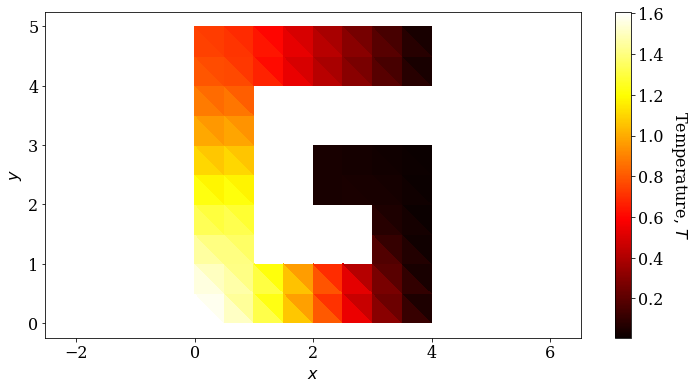

In [10]:
plot_temperature_triplot(nodes, IEN, tri_size, T)

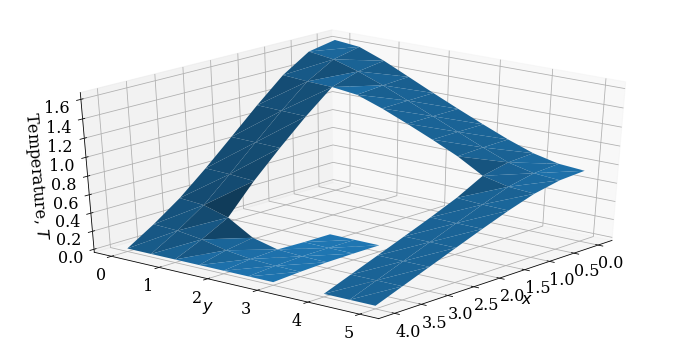

In [11]:
plot_temperature_tri_surf(nodes, IEN, tri_size, T)

# Triangle elements of short side length 1/16

In [12]:
# =============================================================================
# Run the functions and plot the results
# =============================================================================

if __name__ == '__main__':

    # run the function tests
    function_tests(msg=True)
    
    start = timeit.default_timer()

    tri_size_16 = 1/16
    nodes_16, IEN_16, ID_16 = generate_g_grid(tri_size_16)
    T_16 = finite_element_2d(nodes_16, IEN_16, ID_16, heat_source)

    stop = timeit.default_timer()

    print('\nSimulation run time: {:6.2f} seconds.'.format(stop - start))

#### Beginning function tests ####

shape_function testing passed.
shape_function_dN testing passed.
local_to_global function testing passed.
jacobian function testing passed.
det_jacobian function testing passed.
global_dN function testing passed.
quadrature functions testing passed.

#### Function tests successful ####

Simulation run time:  21.49 seconds.


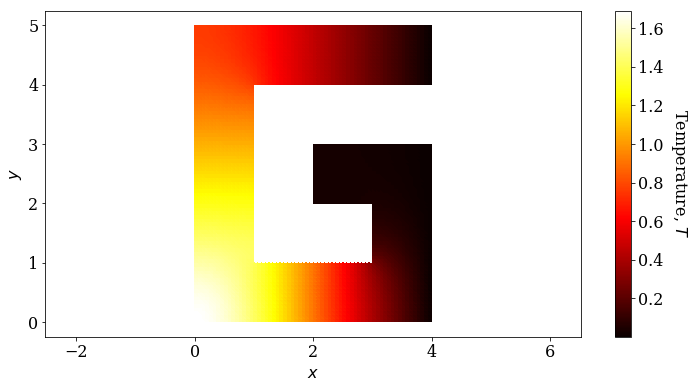

In [13]:
plot_temperature_triplot(nodes_16, IEN_16, tri_size_16, T_16)

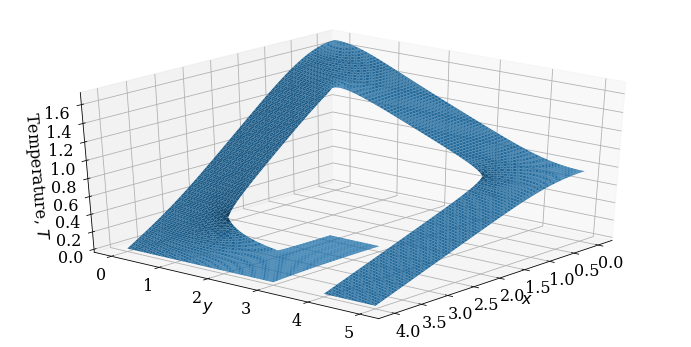

In [14]:
plot_temperature_tri_surf(nodes_16, IEN_16, tri_size_16, T_16)

# Discussion

# Results

** The function f(x, y) is going to change the temperature distribution in the grid. Below is a plot of the function used in the above plots. **

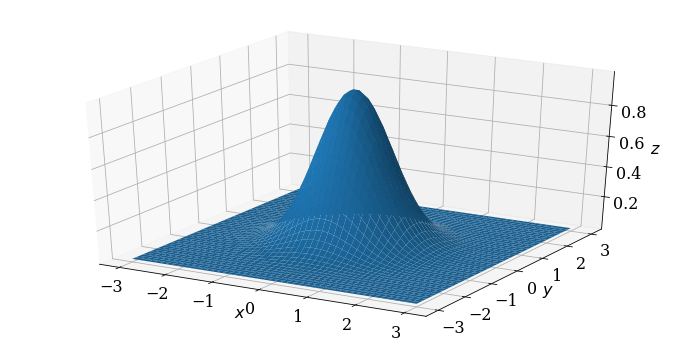

In [15]:
x = np.linspace(-3, 3)
y = np.linspace(-3, 3)

# create meshgrid of the x, y values and define Z
X, Y = np.meshgrid(x, y)
Z = np.exp(-(X ** 2 + Y ** 2))

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_surface(X, Y, Z)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_zlabel('$z$')
plt.show()

** The shape of this function shows that the temperature of the mesh will be greatest at the node at the coordinate (0, 0) which is shown in the plots above. The temperature will then become cooler as the coordinates move away from the peak, which is also shown in the plots above.**

In [16]:
x0_nodes = np.where(nodes[:, 0] == 0)[0]
N = len(x0_nodes)
y0_nodes = np.zeros(N)
T_x0 = np.zeros(N)

for i, index in enumerate(x0_nodes):
    y0_nodes[i] = nodes[index, 1]
    T_x0[i] = T[index]
    
x0_nodes_16 = np.where(nodes_16[:, 0] == 0)[0]
N = len(x0_nodes_16)
y0_nodes_16 = np.zeros(N)
T_x0_16 = np.zeros(N)

for i, index in enumerate(x0_nodes_16):
    y0_nodes_16[i] = nodes_16[index, 1]
    T_x0_16[i] = T_16[index]

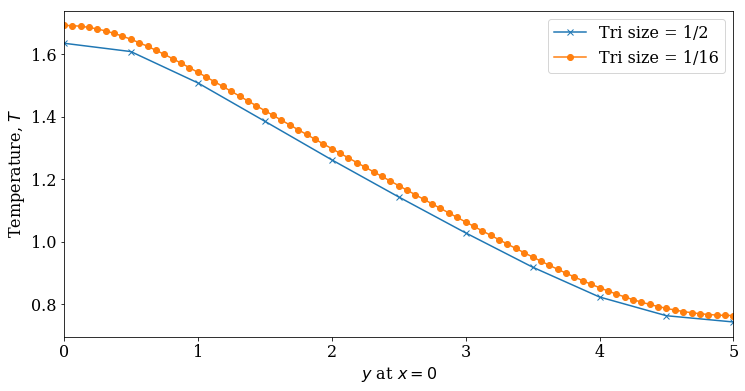

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(y0_nodes, T_x0, 'x-', label='Tri size = 1/2')
ax1.plot(y0_nodes_16, T_x0_16, 'o-', label='Tri size = 1/16')
ax1.set_xlabel('$y$ at $x=0$')
ax1.set_ylabel('Temperature, $T$')
ax1.set_xlim(0, 5)
ax1.legend()
plt.show()

** Above is a plot of the temperature vs y at x=0. There is a difference in the temperature calculated at the different resolutions, but both resolutions follow the same shape. The temperature thus flowing out of the grid at the boundaries where it isn't 0 is different for the different resolutions. **

In [18]:
y0_nodes = np.where(nodes[:, 1] == 0)[0]
N = len(y0_nodes)
x0_nodes = np.zeros(N)
T_y0 = np.zeros(N)

for i, index in enumerate(y0_nodes):
    x0_nodes[i] = nodes[index, 0]
    T_y0[i] = T[index]
    
y0_nodes_16 = np.where(nodes_16[:, 1] == 0)[0]
N = len(y0_nodes_16)
x0_nodes_16 = np.zeros(N)
T_y0_16 = np.zeros(N)

for i, index in enumerate(y0_nodes_16):
    x0_nodes_16[i] = nodes_16[index, 0]
    T_y0_16[i] = T_16[index]

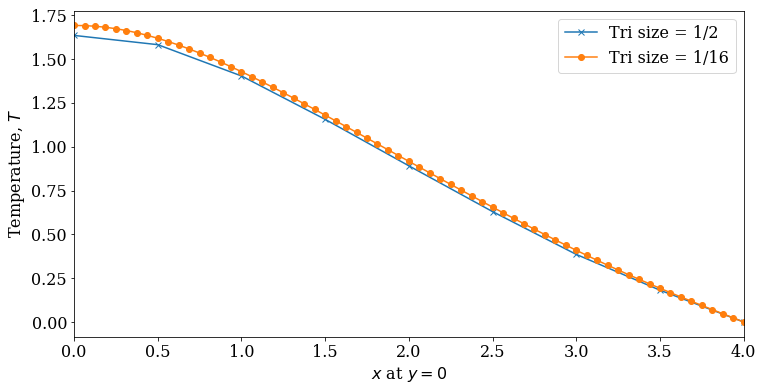

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x0_nodes, T_y0, 'x-', label='Tri size = 1/2')
ax1.plot(x0_nodes_16, T_y0_16, 'o-', label='Tri size = 1/16')
ax1.set_xlabel('$x$ at $y=0$')
ax1.set_ylabel('Temperature, $T$')
ax1.set_xlim(0, 4)
ax1.legend()
plt.show()

** Here again the temperature  of the higher resolution grid is larger, but in this direction the temperatures are much closer together. Both resolutions have a T = 0 at x = 4, which is the boundary condition. **

** Plotted below is the temperature at y where x = 0 for more resolutions. **

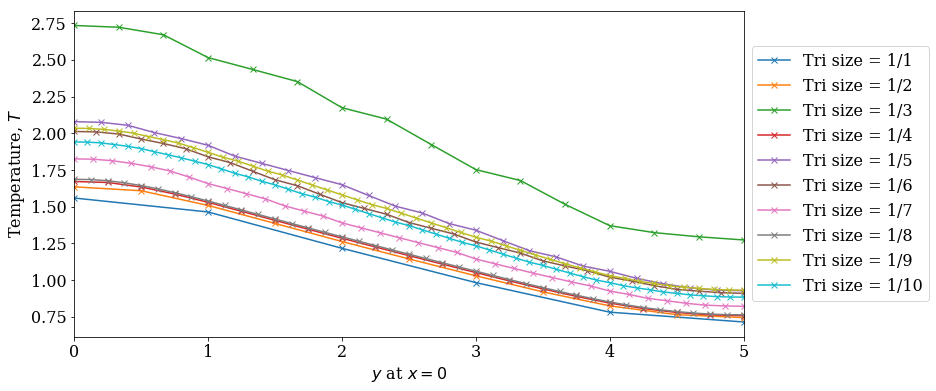

In [20]:
Ns = np.arange(1, 11, 1)

for N in Ns:
    tri_size = 1/N
    nodes, IEN, ID = generate_g_grid(tri_size)
    T = finite_element_2d(nodes, IEN, ID, heat_source)

    x0_nodes = np.where(nodes[:, 0] == 0)[0]
    N_nodes = len(x0_nodes)
    y0_nodes = np.zeros(N_nodes)
    T_x0 = np.zeros(N_nodes)

    for i, index in enumerate(x0_nodes):
        y0_nodes[i] = nodes[index, 1]
        T_x0[i] = T[index]
        
    plt.plot(y0_nodes, T_x0, 'x-', 
             label='Tri size = 1/{}'.format(N))

plt.xlabel('$y$ at $x=0$')
plt.ylabel('Temperature, $T$')
plt.xlim(0, 5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.show()

** Strangely for tri size = 1/3, there is a large jump in temperature. However, the temperatures of the other resolutions are closer together. The width of the temperatures is quite large, at around 0.5 at y=0, but becomes smaller as y -> 5.** 

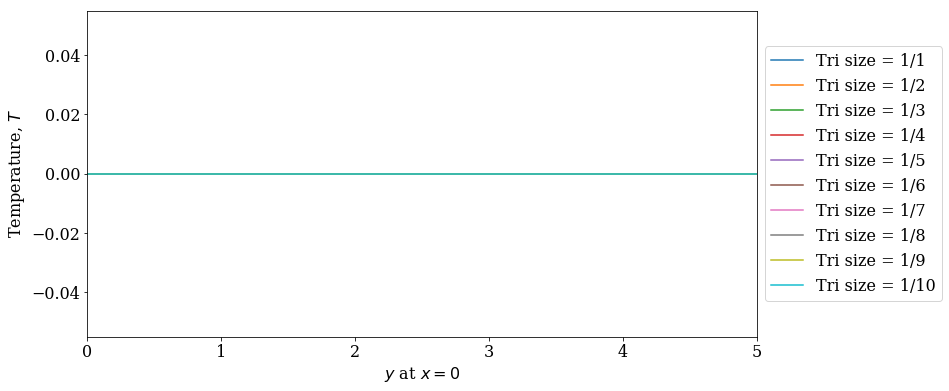

In [21]:
Ns = np.arange(1, 11, 1)

for N in Ns:
    tri_size = 1/N
    nodes, IEN, ID = generate_g_grid(tri_size)
    T = finite_element_2d(nodes, IEN, ID, heat_source)

    x0_nodes = np.where(nodes[:, 0] == 4)[0]
    N_nodes = len(x0_nodes)
    y0_nodes = np.zeros(N_nodes)
    T_x0 = np.zeros(N_nodes)

    for i, index in enumerate(x0_nodes):
        y0_nodes[i] = nodes[index, 1]
        T_x0[i] = T[index]
        
    plt.plot(y0_nodes, T_x0, '-', 
             label='Tri size = 1/{}'.format(N))

plt.xlabel('$y$ at $x=0$')
plt.ylabel('Temperature, $T$')
plt.xlim(0, 5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.show()

** Looking at the right hand boundary, the temperature is 0 is as expected and defined by the boundary conditions of the problem. **

# A Different Heat Function

In [22]:
def heat_source2(x):
    """
    The function used to define the heat source.

    Parameters
    ----------
    x: 1 x 2 array of floats. The x, y coordinates of the global location for
        a reference point of an element.

    Returns
    -------
    Float. The value of the heat source at the reference point for an element.
    """

    assert(len(x) == 2), 'The array does not contain two coordinate locations.'

    return x[0] ** 2 * (x[0] - 1) * (x[1] ** 2 + 4 * x[1] *
                                     (x[1] - 1) + (x[1] - 1) ** 2) + \
            x[1] ** 2 * (3 * x[0] - 1) * (x[1] - 1) ** 2

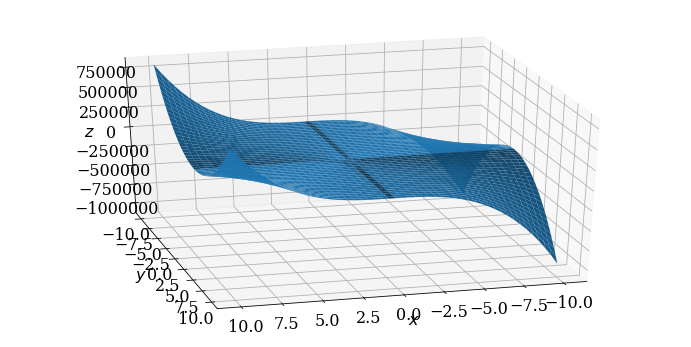

In [29]:
x = np.linspace(-10, 10)
y = np.linspace(-10, 10)

X, Y = np.meshgrid(x, y)
Z = X ** 2 * (X - 1) * (Y ** 2 + 4 * Y * (Y - 1) + \
    (Y - 1) ** 2) + Y ** 2 * (3 * X - 1) * (X - 1) ** 2

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_surface(X, Y, Z)
ax1.view_init(30, 75)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_zlabel('$z$')
plt.show()

** This creates a very odd shaped surface. The temperature is either a minimum of a maximum at the corners of the surface plotted. **

In [25]:
# =============================================================================
# Heat Source 2
# =============================================================================

if __name__ == '__main__':

    # run the function tests
    function_tests()
    
    start = timeit.default_timer()

    # define the size of the triangular elements, this must be < 1
    tri_size = 1/6
    # construct the grid
    nodes, IEN, ID = generate_g_grid(tri_size)
    # solve for the temperature using finite elements and plot the results
    T_2 = finite_element_2d(nodes, IEN, ID, heat_source2)

    stop = timeit.default_timer()

    print('\nSimulation run time: {:6.2f} seconds.'.format(stop - start))


Simulation run time:   2.82 seconds.


## Heat Source 2

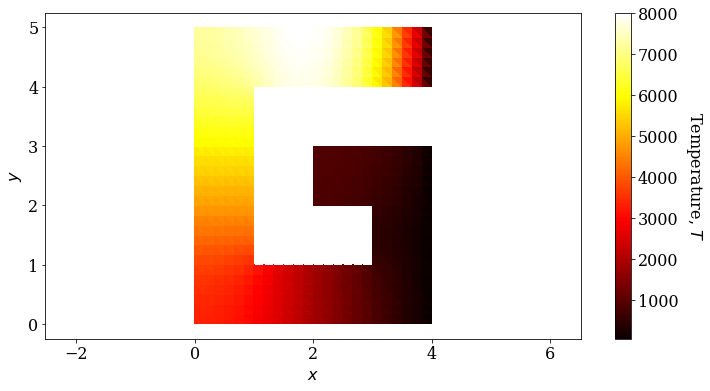

In [26]:
plot_temperature_triplot(nodes, IEN, tri_size, T_2)

** Due to the shape of the function, the hottest part is now at the top of the G. However, there is a large temperature gradient near the right hand boundary.** 

** Changing the heat source function chanes the temperature distribution as expected. Heat soure 2 returns a distribution with a much large temperature than heat source 1 and 2. Heat source 2 also returns larger temperatures. Due to the boundary conditions, the right edge is still T = 0, but with the region defined (2, 2), (4, 2), (2, 3), (4, 3) is no longer as cool as it was in the original heat source.**

## Run Time v Number of Elements

**This takes about 5 minutes to run..**

In [27]:
Ns = np.arange(1, 21, 1)
N = len(Ns)
run_times = np.zeros(N)
num_elements = np.zeros(N)
max_T = np.zeros(N)

for i, N in enumerate(Ns):
    start = timeit.default_timer()
    tri_size = 1/N
    nodes, IEN, ID = generate_g_grid(tri_size)
    T = finite_element_2d(nodes, IEN, ID, heat_source)
    stop = timeit.default_timer()
    
    run_times[i] = stop - start
    num_elements[i] = IEN.shape[0]
    max_T[i] = np.max(T)

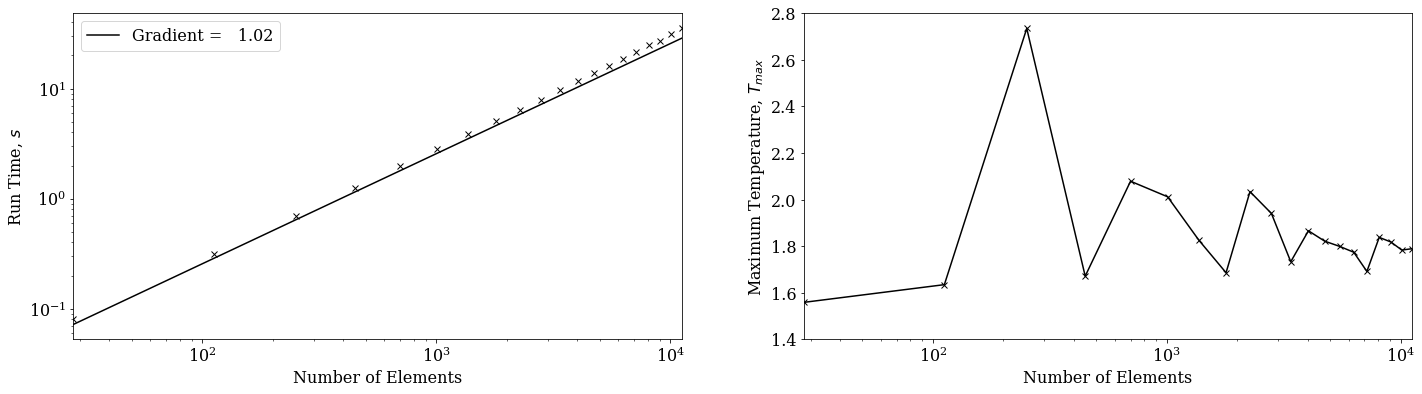

In [28]:
fig = plt.figure(figsize=(24, 6))

fit = np.polyfit(np.log(num_elements), np.log(run_times), 1)

ax1 = fig.add_subplot(121)
ax1.loglog(num_elements, run_times, 'kx')
ax1.loglog(num_elements, num_elements * np.exp(fit[1]), 
           'k', label='Gradient = {:6.2f}'.format(fit[0]))
ax1.set_xlim(num_elements[0], num_elements[-1])
ax1.set_xlabel('Number of Elements')
ax1.set_ylabel('Run Time, $s$')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.semilogx(num_elements, max_T, 'kx-')
ax2.set_xlim(num_elements[0], num_elements[-1])
ax2.set_xlabel('Number of Elements')
ax2.set_ylabel('Maximum Temperature, $T_{max}$')
ax2.set_ylim(1.4, 2.8)

plt.show()

** As expected, the run time of each simulation increases with the number of elements. Run time appears to increase linearly with the number of elements. **



** The maximum temperature in the grid changes with the number of elements. It looks as if the temperature increases with number of elements, but the curve is not smooth with jumps up and down the maximum temperature. ** 